# Traveling waves emerge in a cortical network model and follow structural connectivity in-strength gradients in the human connectome

In [2]:
import os, sys
import yaml
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
import pyvista as pv
import seaborn as sns

from modules.visualization import *
from modules.helpers import *

from palettable.cartocolors.qualitative import Safe_10
from palettable.scientific.sequential import LaPaz_20
from palettable.cmocean.sequential import Ice_20

import cmasher as cmr
cmap_potential = cmr.eclipse

cmap_waves = Ice_20.mpl_colormap
cmap_fq = LaPaz_20.mpl_colormap

c1 = '#3baa70'
c2 = '#703baa'

clrs = Safe_10.mpl_colors
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", clrs[3:])

dpi = 300
page_width = 2244  # pxl at 300 dpi

In [3]:
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"

In [4]:
# Load Sensor Geometry
# --------------------
# load schaefer surface mesh
with open(os.path.join(data_path, "connectomes/Schaefer2018_HCP_S900/schaefer_surface_mesh.pkl"), 'rb') as f:
    surface_mesh = pickle.load(f)
    
v_lh = surface_mesh['vertices_lh']
f_lh = surface_mesh['faces_lh']
v_rh = surface_mesh['vertices_rh']
f_rh = surface_mesh['faces_rh']
number_of_regions_per_hemi = v_lh.shape[0]
number_of_regions = number_of_regions_per_hemi * 2

# combine left and right hemispheres
v_lh[:,0] = v_lh[:,0] - (v_lh[:,0].max() - v_lh[:,0].min())

v = np.concatenate([v_lh, v_rh])
v[:,0] = v[:,0]
f = np.concatenate([f_lh, f_rh+number_of_regions_per_hemi])

# Overview - Proportion of traveling waves

In [5]:
experiment_id = 30

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [51]:
# Build proportion TWs dataframe for all experiments
experiment_ids = ['30', '31', '32', '34', '38', '39', '33', '50', '51', '48_alpha', '48_beta']
experiments = ['Original', 'Shuffled connections', 'Distance-dependent\nconnections', 'Instrength-normalized', 'Zero delay', 'Constant delay', 'Jansen-Rit', 'Additive noise', 'Random normal\nintrinsic frequency', 'Alpha subnetwork', 'Beta subnetwork']

data = []
for exi, ex_id in enumerate(experiment_ids):
    print(f'processing experiment {ex_id}', end='\r')
    proportion_waves_lh, proportion_waves_rh, proportion_corr_lh, proportion_corr_rh = aggregate_proportions(data_path, ex_id)
    
    data.append(np.column_stack([np.repeat(experiments[exi], 200),
                                 np.concatenate([['left']*number_of_simulations, ['right']*number_of_simulations]),
                                 np.concatenate([proportion_waves_lh*100, proportion_waves_rh*100]),
                                 np.concatenate([proportion_corr_lh*100, proportion_corr_rh*100])
                                ]))

data = np.vstack(data)

df = pd.DataFrame(data, columns=['Experiment', 'Hemisphere', 'Proportion TWs (%)', 'Proportion guided TWs (%)'])
df['Proportion TWs (%)'] = df['Proportion TWs (%)'].astype(float)
df['Proportion guided TWs (%)'] = df['Proportion guided TWs (%)'].astype(float)

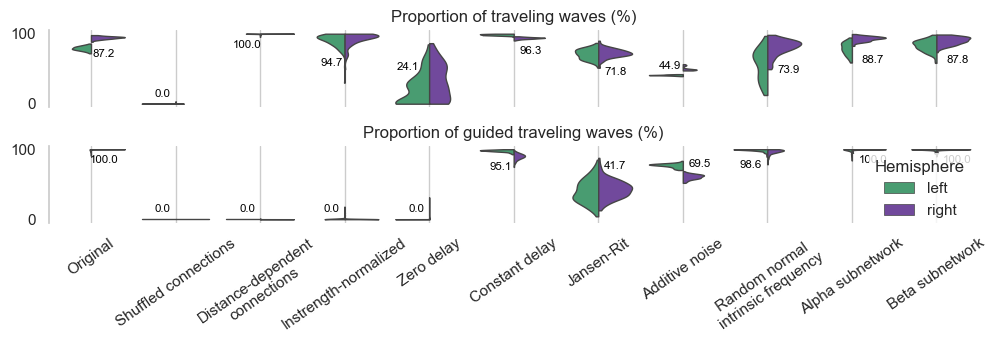

In [60]:
# Plot Proportion Traveling Waves
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,2.5))
plt.subplot(2,1,1)
p = sns.violinplot(df, x='Experiment', y='Proportion TWs (%)', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
#sns.boxplot(df, x='Experiment', y='Proportion TWs (%)', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
p.legend_.remove()
p.set_xticklabels([])
p.set_xlabel('')
#p.set_ylabel('Proportion of\n traveling waves (%)')
p.set_ylabel('')
p.set_title('Proportion of traveling waves (%)')
plt.grid()

medians_proportion_waves = df.groupby(['Experiment'], sort=False)['Proportion TWs (%)'].median()
voffset_proportion_waves = [-20, 10, -20, -40, 25, -25, -30, 5, -30, -30, -30]
hoffset_proportion_waves = [0.15, -0.15, -0.15, -0.15, -0.25, 0.2, 0.2, -0.15, 0.25, 0.25, 0.25]

for xtick in p.get_xticks():
    p.text(xtick + hoffset_proportion_waves[xtick], 
           medians_proportion_waves[xtick] + voffset_proportion_waves[xtick], 
           f"{medians_proportion_waves[xtick]:.1f}", 
           horizontalalignment='center',size='x-small',color='black')

plt.subplot(2,1,2)
p = sns.violinplot(df, x='Experiment', y='Proportion guided TWs (%)', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
#sns.boxplot(df, x='Experiment', y='Proportion guided TWs (%)', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
#p.set_ylabel('Proportion of guided\n traveling waves (%)')
p.set_ylabel('')
p.set_title('Proportion of guided traveling waves (%)')
p.set_xticklabels(p.get_xticklabels(), rotation=35)
p.set_xlabel('')
p.xaxis.set_visible('off')
p.legend_.get_frame().set_linewidth(0)
#p.legend_.remove()
plt.grid()

medians_proportion_guided_waves = df.groupby(['Experiment'], sort=False)['Proportion guided TWs (%)'].median()
voffset_proportion_guided_waves = [-20, 10, 10, 10, 10, -25, 30, 5, -25, -20, -20]
hoffset_proportion_guided_waves = [0.15, -0.15, -0.15, -0.15, -0.15, -0.15, 0.2, 0.2, -0.2, 0.25, 0.25]

for xtick in p.get_xticks():
    p.text(xtick + hoffset_proportion_guided_waves[xtick], 
           medians_proportion_guided_waves[xtick] + voffset_proportion_guided_waves[xtick], 
           f"{medians_proportion_guided_waves[xtick]:.1f}", 
           horizontalalignment='center',size='x-small',color='black')

plt.subplots_adjust(hspace=0.5)
sns.despine(bottom=True)

#plt.savefig(os.path.join(figure_path, f'proportion_waves.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'proportion_waves.svg'), dpi=300, transparent=True, bbox_inches='tight')

# Cortical Network Model

### Configuration

In [6]:
experiment_id = 30

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [7]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [14]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:0; Simulation ID: 99
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.79 (0.77 - 0.81)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.36 (0.33 - 0.40)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.99  (0.97 - 1.00)
	Average instrength-potential correlation: -0.63 ± 0.02

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.95 (0.93 - 0.96)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.22 (0.17 - 0.24)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (1.00 - 1.00)
	Average instrength-potential correlation: -0.70 ± 0.01


#### Synchronization

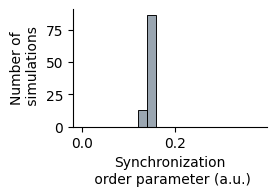

In [7]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [8]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

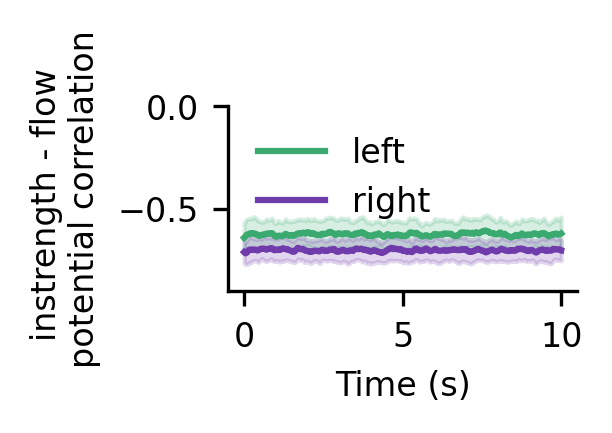

In [9]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.90, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [8]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.74 (p < 0.0)



(-0.7412731652731653, 0.0)

#### Effective frequency distribution

In [11]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [12]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.86 (p < 0.0)



(-0.8550587910587911, 0.0)

#### Create example movie

In [13]:
# load phase
sid = 0
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

In [ ]:
# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 5100, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

In [21]:
# plot example timeseries
# -----------------------
pv.set_plot_theme('document')

cmap = cmap_waves

number_of_timeslices = 5
time_start = 1800
time_end = 1820
timepoints = np.rint(np.linspace(time_start, time_end, number_of_timeslices)).astype(int)

zoom_factor = 1.2

# Build pyvista mesh
mesh = pv.PolyData(v)

# convert faces to pyvista
mesh.faces = np.insert(f.flatten(), np.arange(0,len(f.flatten()),3), 3)

# fill medial wall hole
mesh = mesh.fill_holes(1.).fill_holes(1.)

# create plotter
p = pv.Plotter(shape=(number_of_timeslices,4), col_weights=[1,1,1,0.4], off_screen=True, notebook=True, border=False)

for i, tp in enumerate(timepoints):
    # assign data
    mesh.point_data['data'] = activity[:,tp]
    
    # create point glyphs
    glyphs = mesh.glyph(geom=pv.Sphere(), scale=False, factor=0.01)

    # left
    p.subplot(i,0)
    p.add_text(f"{tp-time_start} ms", font_size=32)
    
    p.add_mesh(mesh, color='white', point_size=0, show_scalar_bar=False, smooth_shading=True, ambient=0.2)
    p.add_mesh(glyphs, scalars='data', cmap=cmap, show_scalar_bar=False, lighting=False)
    
    p.camera_position = 'yz'
    p.camera.azimuth = 180
    p.camera.elevation = 0
    p.camera.zoom(zoom_factor)

    # top
    p.subplot(i,1)
    p.add_mesh(mesh, color='white', point_size=0, show_scalar_bar=False, smooth_shading=True, ambient=0.2)
    p.add_mesh(glyphs, scalars='data', cmap=cmap, show_scalar_bar=False, lighting=False)

    p.camera_position = 'xy'
    p.camera.azimuth = 0
    p.camera.elevation = 0
    p.camera.zoom(zoom_factor)

    # right
    p.subplot(i,2)
    p.add_mesh(mesh, color='white', point_size=0, show_scalar_bar=False, smooth_shading=True, ambient=0.2)
    p.add_mesh(glyphs, scalars='data', cmap=cmap, show_scalar_bar=False, lighting=False)

    p.camera_position = 'yz'
    p.camera.azimuth = 0
    p.camera.elevation = 0
    p.camera.zoom(zoom_factor)

    # lighting
    light1 = pv.Light(light_type='scene light', intensity=0.6)
    light1.set_direction_angle(0, 0)
    p.add_light(light1)

    light2 = pv.Light(light_type='scene light', intensity=0.6)
    light2.set_direction_angle(0, 180)
    p.add_light(light2)

    light3 = pv.Light(light_type='scene light', intensity=0.6)
    light3.set_direction_angle(80, 90)
    p.add_light(light3)

    # colorbar
    p.subplot(i,3)
    p.add_scalar_bar(height=0.7, width=0.6, vertical=True, position_x=0.4, position_y=0.15, n_labels=2, label_font_size=48)

#p.show(window_size=[2256, 912])
p.screenshot(os.path.join(figure_path, f'{experiment_id}_activity_example.png'), transparent_background=True, window_size=[int(2244), int(900)*len(timepoints[:-1])])
p.close()

# Control - Randomly shuffled connection strengths

In [14]:
from scipy.optimize import curve_fit
from sklearn.metrics.pairwise import euclidean_distances

### Configuration

In [15]:
experiment_id = 31

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [16]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

In [17]:
# Fit strength - distance relationship
# ------------------------------------
# Here, we show that if connection strengths are shuffled within existing connections, 
# not only the fiber length - connection strength relationship is destroyed but also the 
# relationship between Euclidean distance - connection strength.

def compute_rsquared(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    return 1 - (ss_res / ss_tot)

def func_powerlaw(x, alpha, beta):
    return alpha * x**beta

def func_explaw(x, alpha, l):
    return alpha * np.exp(-x*l)

def func_linear(x, alpha, beta):
    return beta*x + alpha


# Compute euclidean
euclidean_distance_lh = np.triu(euclidean_distances(v_lh)) * 1e3  # convert m to mm
x_euclid = euclidean_distance_lh[connection_strength_lh!=0]

# randomly permute connection strengths within existing topology
y = np.random.permutation(connection_strength_lh[connection_strength_lh!=0])

# fit models to data
popt_euclid, pcov_euclid = curve_fit(func_powerlaw, x_euclid, y, bounds=((0, -np.inf), (np.inf, 0)))
popt_e_euclid, pcov_e_euclid = curve_fit(func_explaw, x_euclid, y, bounds=((0, 0), (np.inf, np.inf)))
popt_linear_euclid, pcov_linear_euclid = curve_fit(func_linear, x_euclid, y, bounds=((0, 0), (np.inf, np.inf)))

# compute fitted functions
y_powlaw_euclid = func_powerlaw(x_euclid, *popt_euclid)
y_explaw_euclid = func_explaw(x_euclid, *popt_e_euclid)
y_linear_euclid = func_linear(x_euclid, *popt_linear_euclid)

# compute r-squared
r2_powlaw_euclid = compute_rsquared(y, y_powlaw_euclid)
r2_explaw_euclid = compute_rsquared(y, y_explaw_euclid)
r2_linear_euclid = compute_rsquared(y, y_linear_euclid)

# plot results from euclidean distance
plt.figure(figsize=(page_width/dpi, 900/dpi))
plt.scatter(x_euclid, y, color='black', alpha=0.1)
plt.plot(x_euclid, y_powlaw_euclid, '.', alpha=0.5)
plt.plot(x_euclid, y_explaw_euclid, '.', alpha=0.5)
plt.plot(x_euclid, y_linear_euclid, '.', alpha=0.5)
plt.legend(['pow', 'exp', 'linear', 'shuffled data'], frameon=False)
plt.xlabel('Euclidean distance (mm)')
plt.ylabel('Connection strength \n(number of streamlines)')
plt.text(50, 2300, "$R^2_{pow}$ = %.6f"%r2_powlaw_euclid)
plt.text(50, 2000, "$R^2_{exp}$ = %.6f"%r2_explaw_euclid)
plt.text(50, 1700, "$R^2_{linear}$ = %.6f"%r2_linear_euclid)

NameError: name 'connection_strength_lh' is not defined

## Investigate wave and non-wave episodes

### Load and aggregate data

In [18]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:491: RuntimeWarning: Mean of empty slice
  corr_rh_sim[sid] = np.nanmean(corr_rh[sid][wave_mask_div_rh & significant_corr_rh])
/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:443: RuntimeWarning: Mean of empty slice
  corr_lh_sim[sid] = np.nanmean(corr_lh[sid][wave_mask_div_lh & significant_corr_lh])


Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: 0.00 ± 0.00

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: 0.00 ± 0.00


#### Synchronization

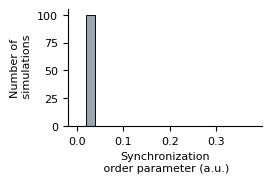

In [19]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [20]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

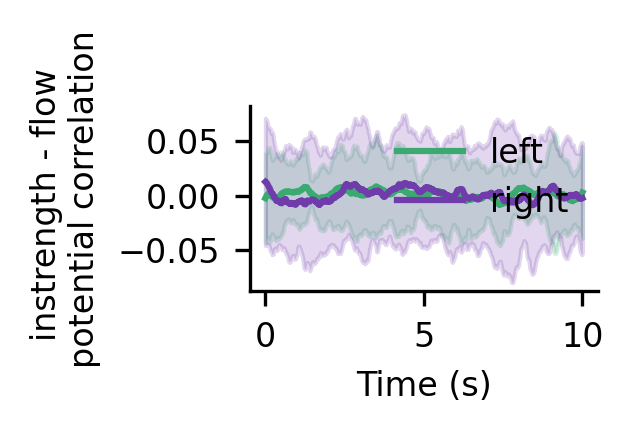

In [21]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [22]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = 0.02 (p < 0.8077)



(0.017383649383649384, 0.8077)

#### Effective frequency distribution

In [23]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [24]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = 0.18 (p < 0.0006)



(0.17749115749115751, 0.0006)

#### Create example movie

In [29]:
# load phase
sid = 1
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

# Control - distance dependent connectivity

In [39]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import euclidean_distances

from palettable.scientific.sequential import Turku_20
cmap_weights = Turku_20.mpl_colormap

In [40]:
experiment_id = 32

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [41]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Fit model to distance-strength relationship
Here, we fit a power law and an exponential model to the empirical relationship between euclidean distance and structural connection strength. The paramters are then used in the actual control simulations to generate the surrogate structural connectivity.

In [45]:
# load connection strengths
number_of_regions = 1000
number_of_regions_per_hemi = 500
connection_strength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/', 'avg_weights.npy'))

connection_strength_lh = np.triu(connection_strength[:number_of_regions_per_hemi,:number_of_regions_per_hemi])  # take upper triangular because of symmetry
connection_strength_rh = np.triu(connection_strength[number_of_regions_per_hemi:number_of_regions,number_of_regions_per_hemi:number_of_regions])
connection_strength_ih = connection_strength[:number_of_regions_per_hemi, number_of_regions_per_hemi:number_of_regions]  # unidirectional intrahemispheric connection strengths

Decay rate of exponential law (euclidean): 0.08 mm-1, Scaling constant: 839.11


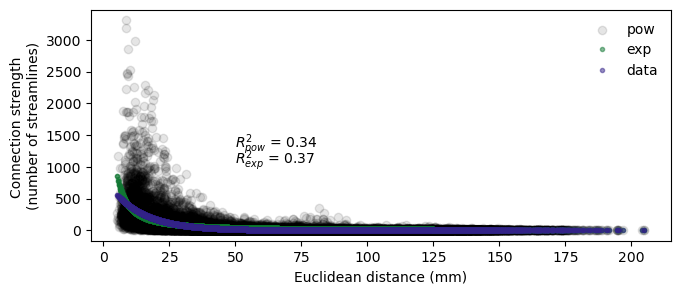

In [46]:
# Fit strength - distance relationship
# ------------------------------------
def compute_rsquared(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    return 1 - (ss_res / ss_tot)

def func_powerlaw(x, alpha, beta):
    return alpha * x**beta

def func_explaw(x, alpha, l):
    return alpha * np.exp(-x*l)

# Compute euclidean
euclidean_distance_lh = np.triu(euclidean_distances(v_lh)) * 1e3  # convert m to mm

# Fit curves euclidean
y = connection_strength_lh[connection_strength_lh!=0]
x_euclid = euclidean_distance_lh[connection_strength_lh!=0]

popt_euclid, pcov_euclid = curve_fit(func_powerlaw, x_euclid, y, bounds=((0, -np.inf), (np.inf, 0)))
popt_e_euclid, pcov_e_euclid = curve_fit(func_explaw, x_euclid, y, bounds=((0, 0), (np.inf, np.inf)))

# compute fitted functions
y_powlaw_euclid = func_powerlaw(x_euclid, *popt_euclid)
y_explaw_euclid = func_explaw(x_euclid, *popt_e_euclid)

# compute r-squared
r2_powlaw_euclid = compute_rsquared(y, y_powlaw_euclid)
r2_explaw_euclid = compute_rsquared(y, y_explaw_euclid)

# plot results from euclidean distance
plt.figure(figsize=(page_width/dpi, 900/dpi))
plt.scatter(x_euclid, y, color='black', alpha=0.1)
plt.plot(x_euclid, y_powlaw_euclid, '.', alpha=0.5)
plt.plot(x_euclid, y_explaw_euclid, '.', alpha=0.5)
plt.legend(['pow', 'exp', 'data'], frameon=False)
plt.xlabel('Euclidean distance (mm)')
plt.ylabel('Connection strength \n(number of streamlines)')
plt.text(50, 1300, "$R^2_{pow}$ = %.2f"%r2_powlaw_euclid)
plt.text(50, 1050, "$R^2_{exp}$ = %.2f"%r2_explaw_euclid)

print(f"Decay rate of exponential law (euclidean): {popt_e_euclid[1]:.2f} mm-1, Scaling constant: {popt_e_euclid[0]:.2f}")
# this exponential distance rule decay rate is consistent with predictions by Theodoni et al. (2022; 'Structural Attributes and Principles of the Neocortical Connectome in the Marmoset Monkey')
# similarly Deco et al. (2021 ;'Rare long-range cortical connections enhance information processing') predict a decay rate of 0.18 mm-1.

#plt.savefig(os.path.join(figure_path, f'{experiment_id}_model_fitting.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_model_fitting.svg'), dpi=300, transparent=True, bbox_inches='tight')

**Figure**: Connection strength - Euclidean distance relationship. The black dots represent the empirical data, purple dots show the exponential model, and green dots the power law. The coefficients of determination $R^2$ for both models indicate that the exponential model is a slightly better fit. Therefore, we used the exponential model for the control simulations. Fitting the exponential model to the geodesic distance instead of the euclidean distance resulted in the same decay rate parameter.

In [47]:
# Generate connectivity from exponential distance rule
# ----------------------------------------------------
connectivity_weight = func_explaw(euclidean_distance_lh, *popt_e_euclid)
connectivity_weight = np.triu(connectivity_weight)  # only use upper triangular
np.fill_diagonal(connectivity_weight, 0)  # remove self-connections

# equalize sum of weights
connectivity_weight /= connectivity_weight.sum()/connection_strength_lh.sum()

# symmetrize connectivity
connectivity_weight = connectivity_weight + connectivity_weight.T - np.diag(np.diag(connectivity_weight))

# match connection density to empirical 
# empirical has connection density of ~20%
connectivity_weight[connectivity_weight<=7] = 0

assert ((connectivity_weight!=0).sum()/number_of_regions_per_hemi**2 > 0.19) & ((connectivity_weight!=0).sum()/number_of_regions_per_hemi**2 < 0.21)

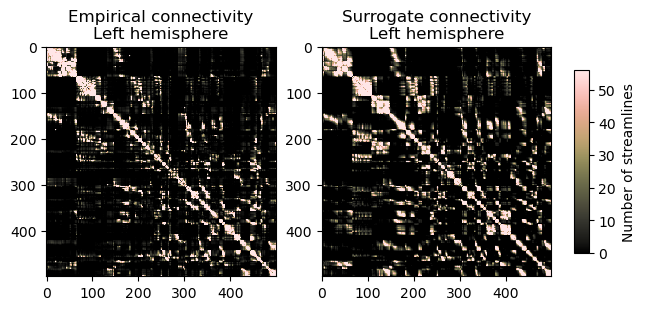

In [48]:
# plot connectivity matrices

# get original connection strength
connection_strength_lh_sym = connection_strength[:number_of_regions_per_hemi,:number_of_regions_per_hemi]

# get percentile of surrogate weights
clim = np.percentile(connectivity_weight, [0, 95])

fig, ax = plt.subplots(1,2, figsize=(page_width/dpi,900/dpi))
im = ax[0].imshow(connection_strength_lh_sym, cmap=cmap_weights, clim=[0,clim[1]])
ax[0].title.set_text('Empirical connectivity\nLeft hemisphere')
ax[1].imshow(connectivity_weight, cmap=cmap_weights, clim=[0,clim[1]])
ax[1].title.set_text('Surrogate connectivity\nLeft hemisphere')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.19, 0.02, 0.61])
fig.colorbar(im, cax=cbar_ax, label='Number of streamlines')


#plt.savefig(os.path.join(figure_path, f'{experiment_id}_surrogate_connectivity.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_surrogate_connectivity.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [97]:
# calculate correlation between empirical and surrogate connectivity
# ------------------------------------------------------------------
spearmanr(connection_strength_lh_sym.flatten(), connectivity_weight.flatten())

SignificanceResult(statistic=0.32335499883464025, pvalue=0.0)

In [51]:
# inspect instrength
import meshplot
meshplot.plot(v_lh, f_lh, connectivity_weight.sum(axis=0))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.080719…

## Control model - distance-dependent connectivity
Analyses of the distance-dependent connectivity control model results.

## Investigate wave and non-wave episodes

### Load and aggregate data

In [42]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:500: RuntimeWarning: Mean of empty slice
  corr_lh_sim[sid] = np.nanmean(corr_lh[sid][wave_mask_div_lh & significant_corr_lh])
/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:548: RuntimeWarning: Mean of empty slice
  corr_rh_sim[sid] = np.nanmean(corr_rh[sid][wave_mask_div_rh & significant_corr_rh])


Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 1.00 (1.00 - 1.00)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.16 (0.12 - 0.20)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: nan ± nan

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 1.00 (1.00 - 1.00)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.19 (0.16 - 0.22)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: -0.29 ± 0.02


/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:565: RuntimeWarning: Mean of empty slice
  corr_lh_time_avg_mean = np.nanmean(corr_lh_sim)
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Synchronization

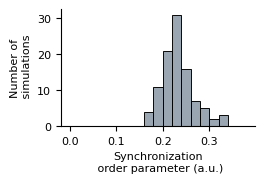

In [29]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [30]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

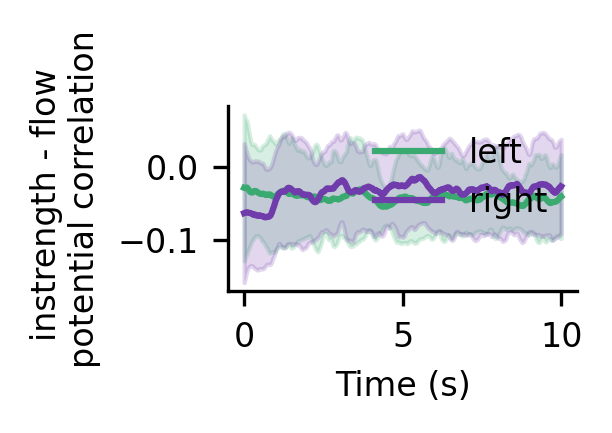

In [31]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [43]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.04 (p < 0.8652)



(-0.043041247041247045, 0.8652)

#### Effective frequency distribution

In [33]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [34]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.07 (p < 0.7682)



(-0.07003087003087004, 0.7682)

### Create movie

In [39]:
# load phase
sid = 0
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

# Control Model - No time delays

### Configuration

In [35]:
experiment_id = 38

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [36]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [37]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:443: RuntimeWarning: Mean of empty slice
  corr_lh_sim[sid] = np.nanmean(corr_lh[sid][wave_mask_div_lh & significant_corr_lh])
/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:491: RuntimeWarning: Mean of empty slice
  corr_rh_sim[sid] = np.nanmean(corr_rh[sid][wave_mask_div_rh & significant_corr_rh])


Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.20 (0.00 - 0.33)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.06 (0.00 - 0.28)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: -0.01 ± 0.05

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.28 (0.07 - 0.53)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.07 (0.00 - 0.23)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: -0.05 ± 0.12


#### Synchronization

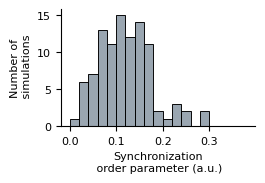

In [38]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [39]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

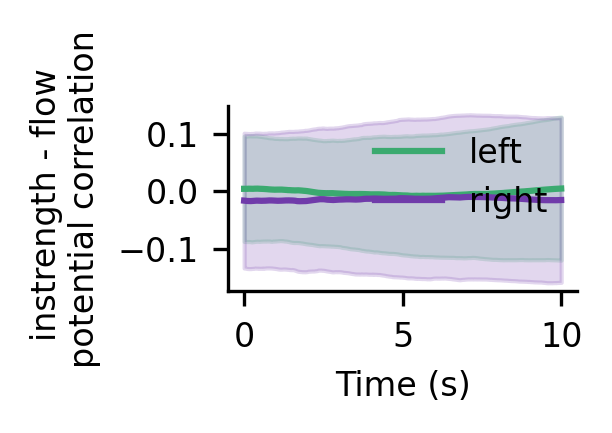

In [40]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [41]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.02 (p < 0.853)



(-0.019443919443919447, 0.853)

#### Effective frequency distribution

In [42]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [43]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.01 (p < 0.7867)



(-0.012551256551256551, 0.7867)

### Create movie

In [100]:
# load phase
sid = 0
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

# Control Model - Constant time delays

### Configuration

In [199]:
experiment_id = 39

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [200]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [201]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.99 (0.98 - 0.99)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.98  (0.97 - 0.99)
	Average instrength-potential correlation: -0.50 ± 0.01

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.94 (0.93 - 0.95)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.00 (0.00 - 0.00)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.90  (0.87 - 0.92)
	Average instrength-potential correlation: -0.48 ± 0.01


#### Synchronization

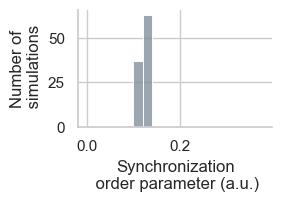

In [202]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [203]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

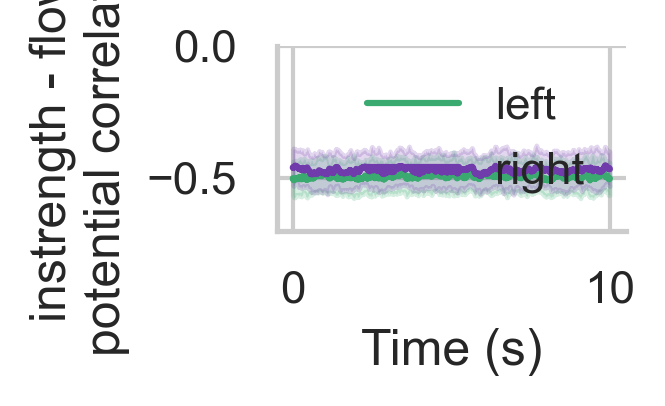

In [204]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.7, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [205]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.64 (p < 0.0)



(-0.6353538713538713, 0.0)

#### Effective frequency distribution

In [206]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [207]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.91 (p < 0.0)



(-0.9148251508251509, 0.0)

### Create movie

In [110]:
# load phase
sid = 0
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

# Control Model - Instrength normalized connectome

### Configuration

In [298]:
experiment_id = 34

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [299]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
simulation_duration = float(config["simulation_duration"])-initial_transient  # ms
number_of_timesteps = int(simulation_duration/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int(simulation_duration/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [300]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:500: RuntimeWarning: Mean of empty slice
  corr_lh_sim[sid] = np.nanmean(corr_lh[sid][wave_mask_div_lh & significant_corr_lh])
/Users/dk/Documents/Charite/PhD/travelingwaves/modules/helpers.py:548: RuntimeWarning: Mean of empty slice
  corr_rh_sim[sid] = np.nanmean(corr_rh[sid][wave_mask_div_rh & significant_corr_rh])


Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.93 (0.86 - 0.97)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.76 (0.67 - 0.87)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: -0.41 ± 0.05

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.96 (0.90 - 0.99)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.87 (0.72 - 0.94)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.00  (0.00 - 0.00)
	Average instrength-potential correlation: -0.36 ± 0.03


#### Synchronization

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

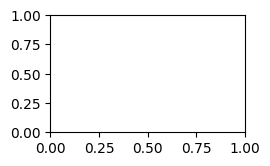

In [10]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

#plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [11]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

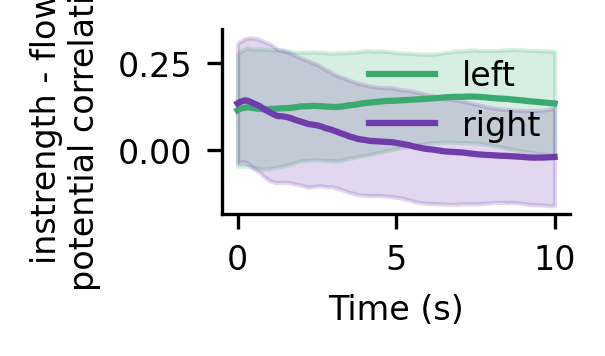

In [12]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim([-0.7, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [13]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = 0.16 (p < 0.1572)



(0.1586947466947467, 0.1572)

#### Effective frequency distribution

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


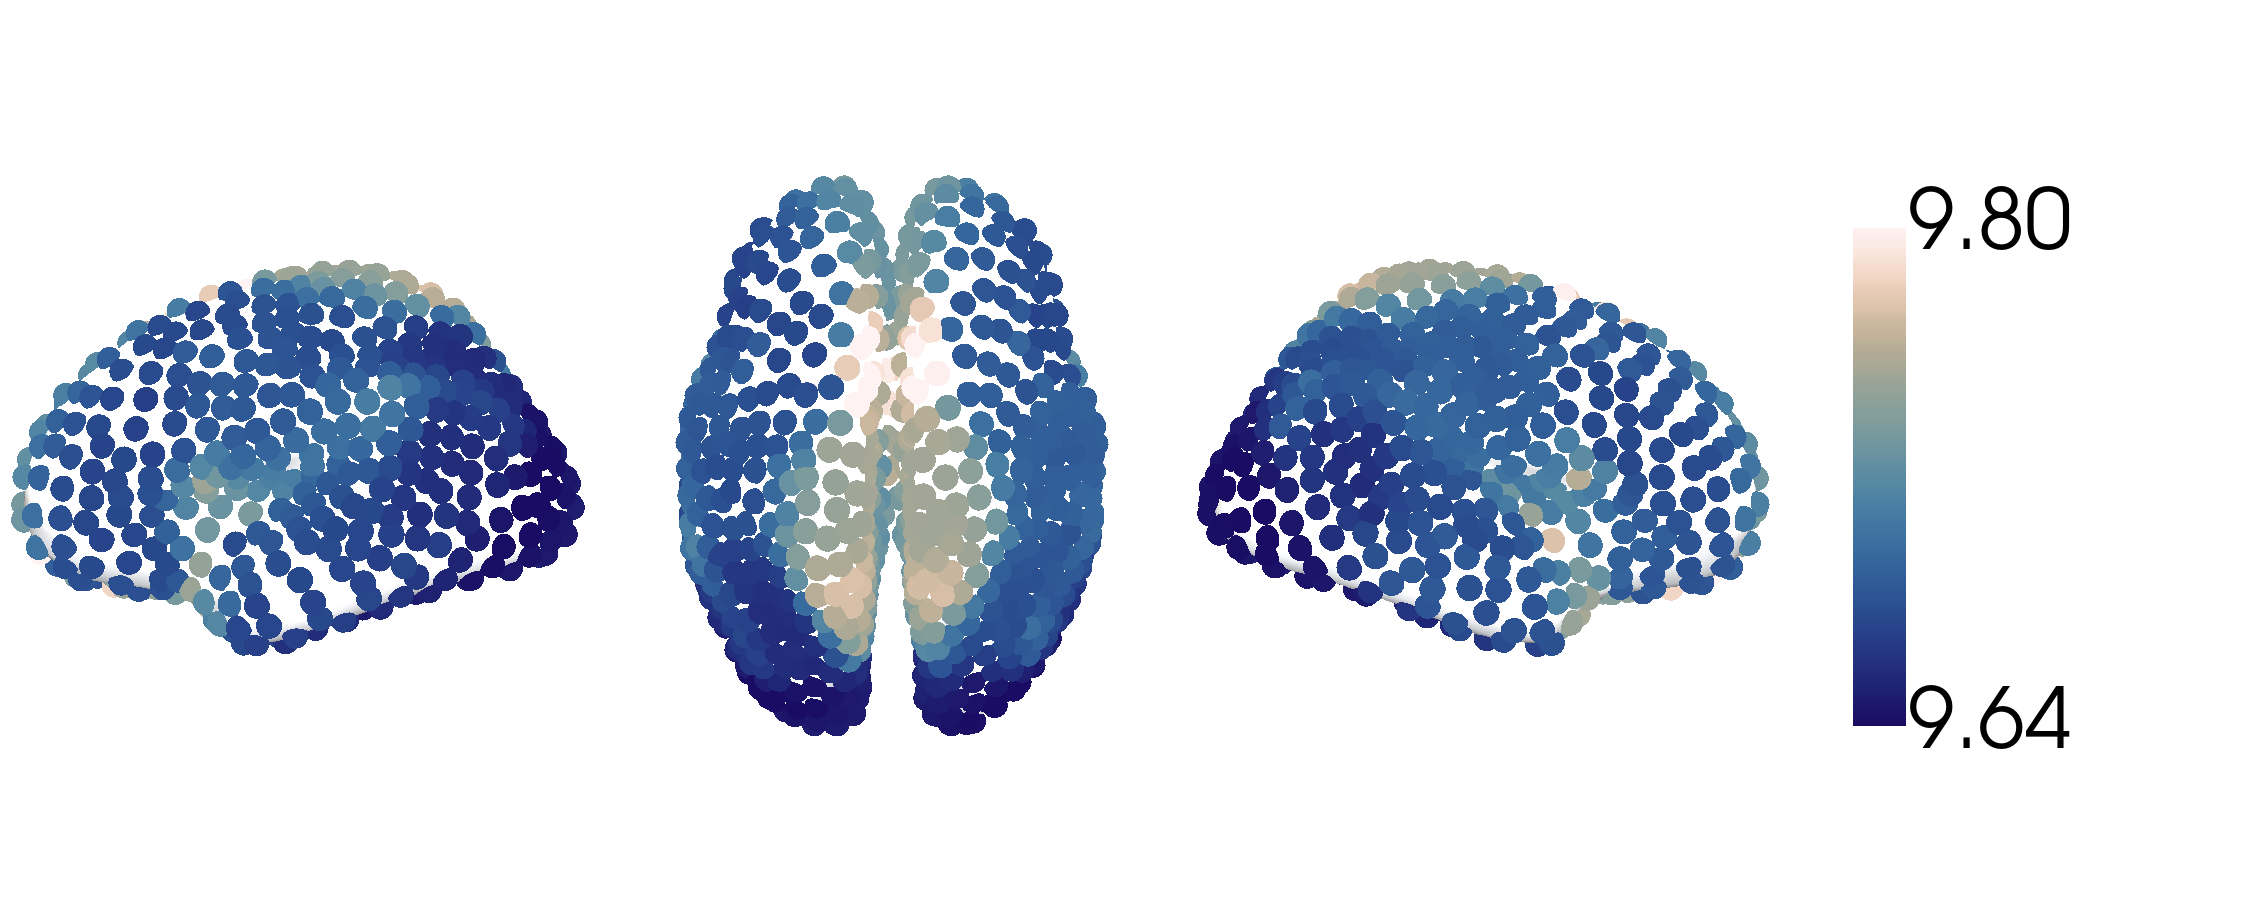

In [88]:
clims = np.percentile(effective_frequency, [1, 99])

plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
#plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

In [41]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.28 (p < 0.0135)



(-0.2794850074850075, 0.0135)

In [42]:
correlation_spin_permutation_testing(wave_potential, effective_frequency, sphere_path=sphere_path)

	correlation = 0.39 (p < 0.0)



(0.38545687345687346, 0.0)

#### Wave potential - graph metric correlation

In [43]:
import networkx as nx

In [44]:
normalized_weights = np.load(os.path.join(data_path,'connectomes/Schaefer2018_HCP_S900/norm_weights.npy'))
normalized_instrength = normalized_weights.sum(axis=0)

G = nx.from_numpy_array(normalized_weights, create_using=nx.Graph)

for edge in G.edges:
    G.add_edge(*edge)

In [45]:
### Node degree ###
node_degree = np.array([val for (node, val) in G.degree()])

correlation_spin_permutation_testing(node_degree, wave_potential, sphere_path=sphere_path)

	correlation = 0.11 (p < 0.0498)



(0.11480114664803379, 0.0498)

In [19]:
### Betweeness ###
betweeness_centrality = np.array(list(nx.betweenness_centrality(G).values()))

correlation_spin_permutation_testing(betweeness_centrality, wave_potential, sphere_path=sphere_path)

	correlation = 0.10 (p < 0.0117)



(0.09841136474455858, 0.0117)

In [20]:
### Eigenvector centrality ###
eig_centrality = np.array(list(nx.eigenvector_centrality(G).values()))

correlation_spin_permutation_testing(eig_centrality, wave_potential, sphere_path=sphere_path)

	correlation = 0.14 (p < 0.2918)



(0.14223014223014224, 0.2918)

### Create movie

In [48]:
# load phase
sid = 0
phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy')).T

# remove transient
phase = phase[:, np.arange(initial_transient_samples, number_of_timesteps+initial_transient_samples, integration_step_size_downsampled).astype(int)]

# convert
activity = np.real(np.exp(1j*phase))

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie_simulation_{sid}.mp4'), cmap=cmap_waves)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/dataset.py:2028: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Control - Jansen-Rit
In this section, we analyze the results of a control model that uses Jansen-Rit neural masses instead of Kuramoto oscillators. This control should ensure that waves emerge in a more biologically realistic model and that they propagate along instrength gradients as they do in the phase-oscillator model.

In [4]:
from scipy.signal import hilbert, butter, sosfiltfilt

### Configuration

In [5]:
experiment_id = 33
 
# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"

In [8]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = float(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)  # samples
final_transient = float(config["final_transient"])  # ms
final_transient_samples = int(final_transient/integration_step_size)  # samples
number_of_timesteps = int((simulation_duration-initial_transient-final_transient)/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient-final_transient)/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [9]:
# bandpass filter settings
f_low = float(config_analysis["f_low"])  # Hz
f_high = float(config_analysis["f_high"])  # Hz
filt_order = 8

# define variables
proportion_waves_lh = np.zeros(number_of_simulations)
proportion_rot_waves_lh = np.zeros(number_of_simulations)

wave_potential_div_lh_sum = np.zeros(number_of_regions_per_hemi)

proportion_corr_lh = np.zeros(number_of_simulations)

corr_lh = np.zeros((number_of_simulations, number_of_timesteps_downsampled))
corr_lh_sim = np.zeros(number_of_simulations)

proportion_waves_rh = np.zeros(number_of_simulations)
proportion_rot_waves_rh = np.zeros(number_of_simulations)

wave_potential_div_rh_sum = np.zeros(number_of_regions_per_hemi)

proportion_corr_rh = np.zeros(number_of_simulations)

corr_rh = np.zeros((number_of_simulations, number_of_timesteps_downsampled))
corr_rh_sim = np.zeros(number_of_simulations)

instantaneous_frequency_lh_sum = np.zeros(number_of_regions_per_hemi)
instantaneous_frequency_rh_sum = np.zeros(number_of_regions_per_hemi)
order_parameter = np.zeros(number_of_simulations)


for sid in simulation_ids:
    # Frequency distribution
    # ----------------------
    ## load activity
    activity = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{sid}.npy'))

    # bandpass filter data
    sos = butter(int(filt_order/2), [f_low, f_high], btype='band', output='sos', fs=1/(integration_step_size*1e-3))
    activity_filt = sosfiltfilt(sos, activity, axis=1)
    
    # remove initial and final transient and downsample timesteps 
    activity = activity_filt[:, initial_transient_samples:-final_transient_samples]
    
    # compute analytic signal
    analytic_signal = hilbert(activity, axis=1)
    phase = np.angle(analytic_signal)

    # compute instantaneous frequency
    instantaneous_frequency = compute_instantaneous_frequency(analytic_signal, integration_step_size*1e-3).T
    instantaneous_frequency = instantaneous_frequency[np.arange(0, number_of_timesteps, integration_step_size_downsampled).astype(int)]  # downsampling
    
    
    # Synchronization
    # ---------------
    # compute kuramoto order parameter
    order_parameter[sid] = np.mean(abs(np.mean(np.exp(1j*phase), axis=0)))
    
    
    # Process divergent activity - left hemi
    # --------------------------------------
    # Find significant singularities (based on angular similarity)
    p_div_lh = np.load(os.path.join(data_path, f'{experiment_id}_analysis', f'{experiment_id}_p_div_lh_{sid}.npy'))
    p_rot_lh = np.load(os.path.join(data_path, f'{experiment_id}_analysis', f'{experiment_id}_p_rot_lh_{sid}.npy'))
    
    significant_div_lh = p_div_lh <= significance_level
    significant_rot_lh = p_rot_lh <= significance_level

    # Create wave mask
    wave_mask_div_lh = np.nansum(significant_div_lh, axis=0, dtype=bool)
    wave_mask_rot_lh = np.nansum(significant_rot_lh, axis=0, dtype=bool)

    # Load HHD potentials
    potential_div_lh = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_potential_div_lh_{sid}.npy'))
    
    
    # Stats
    # -----
    if wave_mask_rot_lh.sum():
        proportion_rot_waves_lh[sid] = np.nansum(wave_mask_rot_lh) / number_of_timesteps_downsampled
        
    if wave_mask_div_lh.sum():
        # compute proportion waves
        proportion_waves_lh[sid] = np.nansum(wave_mask_div_lh) / number_of_timesteps_downsampled

        # Sum up time-averaged potential across waves
        wave_potential_div_lh_sum_tmp = np.nanmean(potential_div_lh[:,wave_mask_div_lh], axis=1)
        wave_potential_div_lh_sum = np.nansum([wave_potential_div_lh_sum, wave_potential_div_lh_sum_tmp], axis=0)
    
        # Load instrength-potential correlation
        corr_lh[sid] = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_corr_div_lh_{sid}.npy'))
        
        # Assess significance of correlation
        p_corr_lh = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_p_corr_lh_{sid}.npy'))
        
        significant_corr_lh = p_corr_lh <= significance_level  # one-sided hypothesis: instrength is negatively correlated to potentials

        # Proportion of significant correlation during waves
        proportion_corr_lh[sid] = np.nansum(significant_corr_lh & wave_mask_div_lh) / np.sum(wave_mask_div_lh)

        # Sum up correlation means
        corr_lh_sim[sid] = np.nanmean(corr_lh[sid][wave_mask_div_lh & significant_corr_lh])

        # instantaneous frequency median
        instantaneous_frequency_lh_sum += np.nanmedian(instantaneous_frequency[wave_mask_div_lh, :number_of_regions_per_hemi], axis=0)


    # Process divergent activity - right hemi
    # --------------------------------------
    # Find significant singularities (based on angular similarity)
    p_div_rh = np.load(os.path.join(data_path, f'{experiment_id}_analysis', f'{experiment_id}_p_div_rh_{sid}.npy'))
    p_rot_rh = np.load(os.path.join(data_path, f'{experiment_id}_analysis', f'{experiment_id}_p_rot_rh_{sid}.npy'))

    significant_div_rh = p_div_rh <= significance_level
    significant_rot_rh = p_rot_rh <= significance_level
    
    # Create wave mask
    wave_mask_div_rh = np.nansum(significant_div_rh, axis=0, dtype=bool)
    wave_mask_rot_rh = np.nansum(significant_rot_rh, axis=0, dtype=bool)

    # Load HHD potentials
    potential_div_rh = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_potential_div_rh_{sid}.npy'))
    
    
    # Stats
    # -----
    if wave_mask_rot_rh.sum():
        proportion_rot_waves_rh[sid] = np.nansum(wave_mask_rot_rh) / number_of_timesteps_downsampled
    
    if wave_mask_div_rh.sum():
        # compute proportion waves
        proportion_waves_rh[sid] = np.nansum(wave_mask_div_rh) / number_of_timesteps_downsampled

        # Sum up time-averaged potential across waves
        wave_potential_div_rh_sum_tmp = np.nanmean(potential_div_rh[:,wave_mask_div_rh], axis=1)
        wave_potential_div_rh_sum = np.nansum([wave_potential_div_rh_sum, wave_potential_div_rh_sum_tmp], axis=0)
    
        # Load instrength-potential correlation
        corr_rh[sid] = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_corr_div_rh_{sid}.npy'))
        
        # Assess significance of correlation
        p_corr_rh = np.load(os.path.join(data_path, f'{experiment_id}_analysis_potentials', f'{experiment_id}_p_corr_rh_{sid}.npy'))
        
        significant_corr_rh = p_corr_rh <= significance_level  # one-sided hypothesis: instrength is negatively correlated to potentials

        # Proportion of significant correlation during waves
        proportion_corr_rh[sid] = np.nansum(significant_corr_rh & wave_mask_div_rh) / np.sum(wave_mask_div_rh)

        # Sum up correlation means
        corr_rh_sim[sid] = np.nanmean(corr_rh[sid][wave_mask_div_rh & significant_corr_rh])

        # instantaneous frequency median
        instantaneous_frequency_rh_sum += np.nanmedian(instantaneous_frequency[wave_mask_div_rh, number_of_regions_per_hemi:], axis=0)


# Aggregate stats - left hemi
wave_potential_div_lh_mean = wave_potential_div_lh_sum / number_of_simulations

proportion_waves_lh_median = np.nanmedian(proportion_waves_lh)
proportion_rot_waves_lh_median = np.nanmedian(proportion_rot_waves_lh)
proportion_corr_lh_median = np.nanmedian(proportion_corr_lh)

proportion_waves_lh_quartiles = np.nanpercentile(proportion_waves_lh, [25, 75])
proportion_rot_waves_lh_quartiles = np.nanpercentile(proportion_rot_waves_lh, [25, 75])
proportion_corr_lh_quartiles = np.nanpercentile(proportion_corr_lh, [25, 75])

corr_lh_time_avg_mean = np.nanmean(corr_lh_sim)
corr_lh_time_avg_sd = np.nanstd(corr_lh_sim)

corr_lh_mean = np.nanmean(corr_lh, axis=0)
corr_lh_sd = np.nanstd(corr_lh, axis=0)

instantaneous_frequency_lh_mean = instantaneous_frequency_lh_sum / number_of_simulations


# Aggregate stats - right hemi
wave_potential_div_rh_mean = wave_potential_div_rh_sum / number_of_simulations

proportion_waves_rh_median = np.nanmedian(proportion_waves_rh)
proportion_rot_waves_rh_median = np.nanmedian(proportion_rot_waves_rh)
proportion_corr_rh_median = np.nanmedian(proportion_corr_rh)

proportion_waves_rh_quartiles = np.nanpercentile(proportion_waves_rh, [25, 75])
proportion_rot_waves_rh_quartiles = np.nanpercentile(proportion_rot_waves_rh, [25, 75])
proportion_corr_rh_quartiles = np.nanpercentile(proportion_corr_rh, [25, 75])

corr_rh_time_avg_mean = np.nanmean(corr_rh_sim)
corr_rh_time_avg_sd = np.nanstd(corr_rh_sim)

corr_rh_mean = np.nanmean(corr_rh, axis=0)
corr_rh_sd = np.nanstd(corr_rh, axis=0)

instantaneous_frequency_rh_mean = instantaneous_frequency_rh_sum / number_of_simulations

wave_potential = np.concatenate([wave_potential_div_lh_mean, wave_potential_div_rh_mean])
effective_frequency = np.concatenate([instantaneous_frequency_lh_mean, instantaneous_frequency_rh_mean])
corr_mean = [corr_lh_mean, corr_rh_mean]
corr_sd = [corr_lh_sd, corr_rh_sd]

# Print stats
print(f"Left Hemisphere:\n"
    f"\tMedian (IQR) proportion of source-sink wave episodes across simulation duration: {proportion_waves_lh_median:.2f} ({proportion_waves_lh_quartiles[0]:.2f} - {proportion_waves_lh_quartiles[1]:.2f})\n"
    f"\tMedian (IQR) proportion of rotating wave episodes across simulation duration: {proportion_rot_waves_lh_median:.2f} ({proportion_rot_waves_lh_quartiles[0]:.2f} - {proportion_rot_waves_lh_quartiles[1]:.2f})\n"
    f"\tMedian (IQR) proportion of instrength-guided waves across wave episodes: {proportion_corr_lh_median:.2f}  ({proportion_corr_lh_quartiles[0]:.2f} - {proportion_corr_lh_quartiles[1]:.2f})\n"
    f"\tAverage instrength-potential correlation: {corr_lh_time_avg_mean:.2f} \u00B1 {corr_lh_time_avg_sd:.2f}\n\n"
    f"Right Hemisphere:\n"
    f"\tMedian (IQR) proportion of source-sink wave episodes across simulation duration: {proportion_waves_rh_median:.2f} ({proportion_waves_rh_quartiles[0]:.2f} - {proportion_waves_rh_quartiles[1]:.2f})\n"
    f"\tMedian (IQR) proportion of rotating wave episodes across simulation duration: {proportion_rot_waves_rh_median:.2f} ({proportion_rot_waves_rh_quartiles[0]:.2f} - {proportion_rot_waves_rh_quartiles[1]:.2f})\n"
    f"\tMedian (IQR) proportion of instrength-guided waves across wave episodes: {proportion_corr_rh_median:.2f}  ({proportion_corr_rh_quartiles[0]:.2f} - {proportion_corr_rh_quartiles[1]:.2f})\n"
    f"\tAverage instrength-potential correlation: {corr_rh_time_avg_mean:.2f} \u00B1 {corr_rh_time_avg_sd:.2f}"
    )

Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.75 (0.69 - 0.80)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.73 (0.66 - 0.77)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.39  (0.28 - 0.53)
	Average instrength-potential correlation: -0.43 ± 0.03

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.76 (0.73 - 0.80)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.74 (0.70 - 0.77)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.43  (0.33 - 0.51)
	Average instrength-potential correlation: -0.44 ± 0.03


#### Synchronization

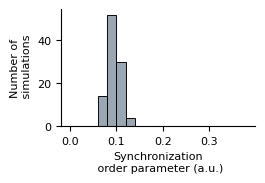

In [103]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [10]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

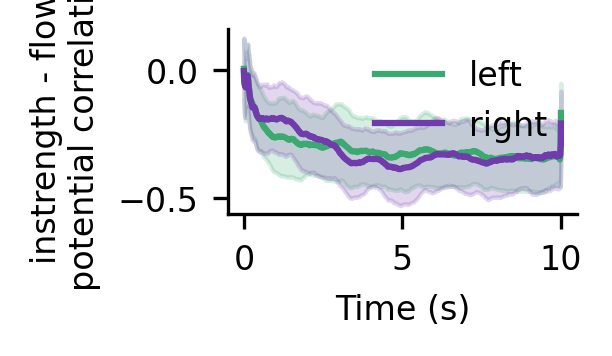

In [11]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [12]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

NameError: name 'sphere_path' is not defined

#### Effective frequency distribution

In [ ]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

In [ ]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

### Create movie

In [13]:
# load phase
sid = 74

## load activity
activity = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sid}.npy"))

# bandpass filter data
f_low = float(config_analysis["f_low"])  # Hz
f_high = float(config_analysis["f_high"])  # Hz
filt_order = 8
sos = butter(int(filt_order/2), [f_low, f_high], btype='band', output='sos', fs=1/(integration_step_size*1e-3))
activity_filt = sosfiltfilt(sos, activity, axis=1)

# remove initial and final transient and downsample timesteps 
activity = activity_filt[:, initial_transient_samples:-final_transient_samples]

clim = np.percentile(activity.flatten(), [5, 95])

# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 8000, 10000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves, clim=clim)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/dataset.py:1941: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Control - Noisy Cortical Network Model
We added noise to the orginal cortical model to test if the results are robust against noise.

In [109]:
from scipy.signal import butter, sosfiltfilt, hilbert

### Configuration

In [110]:
experiment_id = 50

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [111]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)
final_transient = float(config["final_transient"])  # ms
final_transient_samples = int(final_transient/integration_step_size)  # samples

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient-final_transient)/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [112]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.41 (0.41 - 0.41)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.02 (0.02 - 0.02)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.78  (0.76 - 0.79)
	Average instrength-potential correlation: -0.42 ± 0.00

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.49 (0.48 - 0.49)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.08 (0.07 - 0.08)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.61  (0.58 - 0.63)
	Average instrength-potential correlation: -0.43 ± 0.01


#### Synchronization

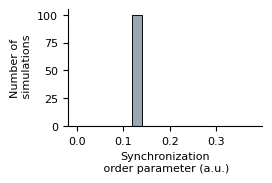

In [113]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [114]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

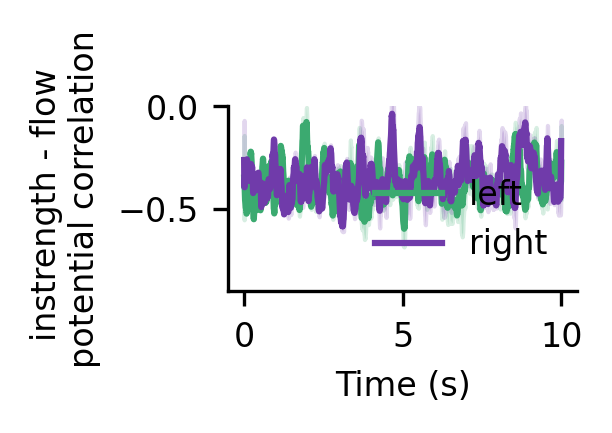

In [115]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.90, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [116]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.60 (p < 0.0)



(-0.6034919314919316, 0.0)

#### Effective frequency distribution

In [117]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [118]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.74 (p < 0.0)



(-0.7395007275007275, 0.0)

#### Create example movie

In [36]:
# load phase
sid = 0

## load phase
phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sid}.npy")).T
activity = np.cos(phase)

# bandpass filter data
f_low = float(config_analysis["f_low"])  # Hz
f_high = float(config_analysis["f_high"])  # Hz
filt_order = 8
sos = butter(int(filt_order/2), [f_low, f_high], btype='band', output='sos', fs=1/(integration_step_size*1e-3))
activity_filt = sosfiltfilt(sos, activity, axis=1)

# remove initial and final transient and downsample timesteps 
activity = activity_filt[:, initial_transient_samples:-final_transient_samples]
activity = activity[:, np.arange(0, activity.shape[1], integration_step_size_downsampled).astype(int)]

In [38]:
# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/dataset.py:2028: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Control - Intrinsic frequency dispersion
We parameterized the intrinsic frequency as a gaussian distribution with mean 10 Hz and standard deviation 1 Hz to test if the results are robust against noise in the intrinsic frequency distribution.

### Configuration

In [129]:
experiment_id = 51

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [131]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient)/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [133]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.61 (0.38 - 0.73)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.03 (0.02 - 0.04)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (0.98 - 1.00)
	Average instrength-potential correlation: -0.60 ± 0.02

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.83 (0.74 - 0.89)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.05 (0.03 - 0.08)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 0.98  (0.95 - 0.99)
	Average instrength-potential correlation: -0.59 ± 0.02


#### Synchronization

In [145]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

In [135]:
cabs = np.max(np.abs(wave_potential))

#plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


#### Plot average instrength-potential correlation

In [146]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.90, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [137]:
# compute instrength - potential correlation
instrength = np.load(os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/instrength.npy'))

correlation_spin_permutation_testing(instrength, wave_potential, sphere_path=sphere_path)

	correlation = -0.74 (p < 0.0)



(-0.7352417912417913, 0.0)

#### Effective frequency distribution

In [138]:
clims = np.percentile(effective_frequency, [1, 99])

#plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [139]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength, effective_frequency, sphere_path=sphere_path)

	correlation = -0.89 (p < 0.0)



(-0.8879392799392799, 0.0)

#### Create example movie

In [150]:
# load phase
sid = 0

## load phase
phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sid}.npy")).T
activity = np.cos(phase[:,initial_transient_samples:])

activity = activity[:, np.arange(0, activity.shape[1], integration_step_size_downsampled).astype(int)]

In [152]:
# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/dataset.py:1941: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Alpha subnetwork model

### Configuration

In [4]:
experiment_id = '48_alpha'

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [5]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient)/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [7]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:8_alpha; Simulation ID: 99
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.79 (0.72 - 0.86)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.49 (0.38 - 0.57)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (0.99 - 1.00)
	Average instrength-potential correlation: -0.74 ± 0.01

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.94 (0.90 - 0.95)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.25 (0.18 - 0.38)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (1.00 - 1.00)
	Average instrength-potential correlation: -0.69 ± 0.02


#### Synchronization

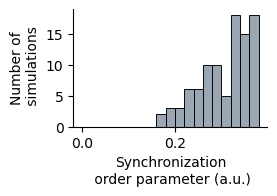

In [8]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


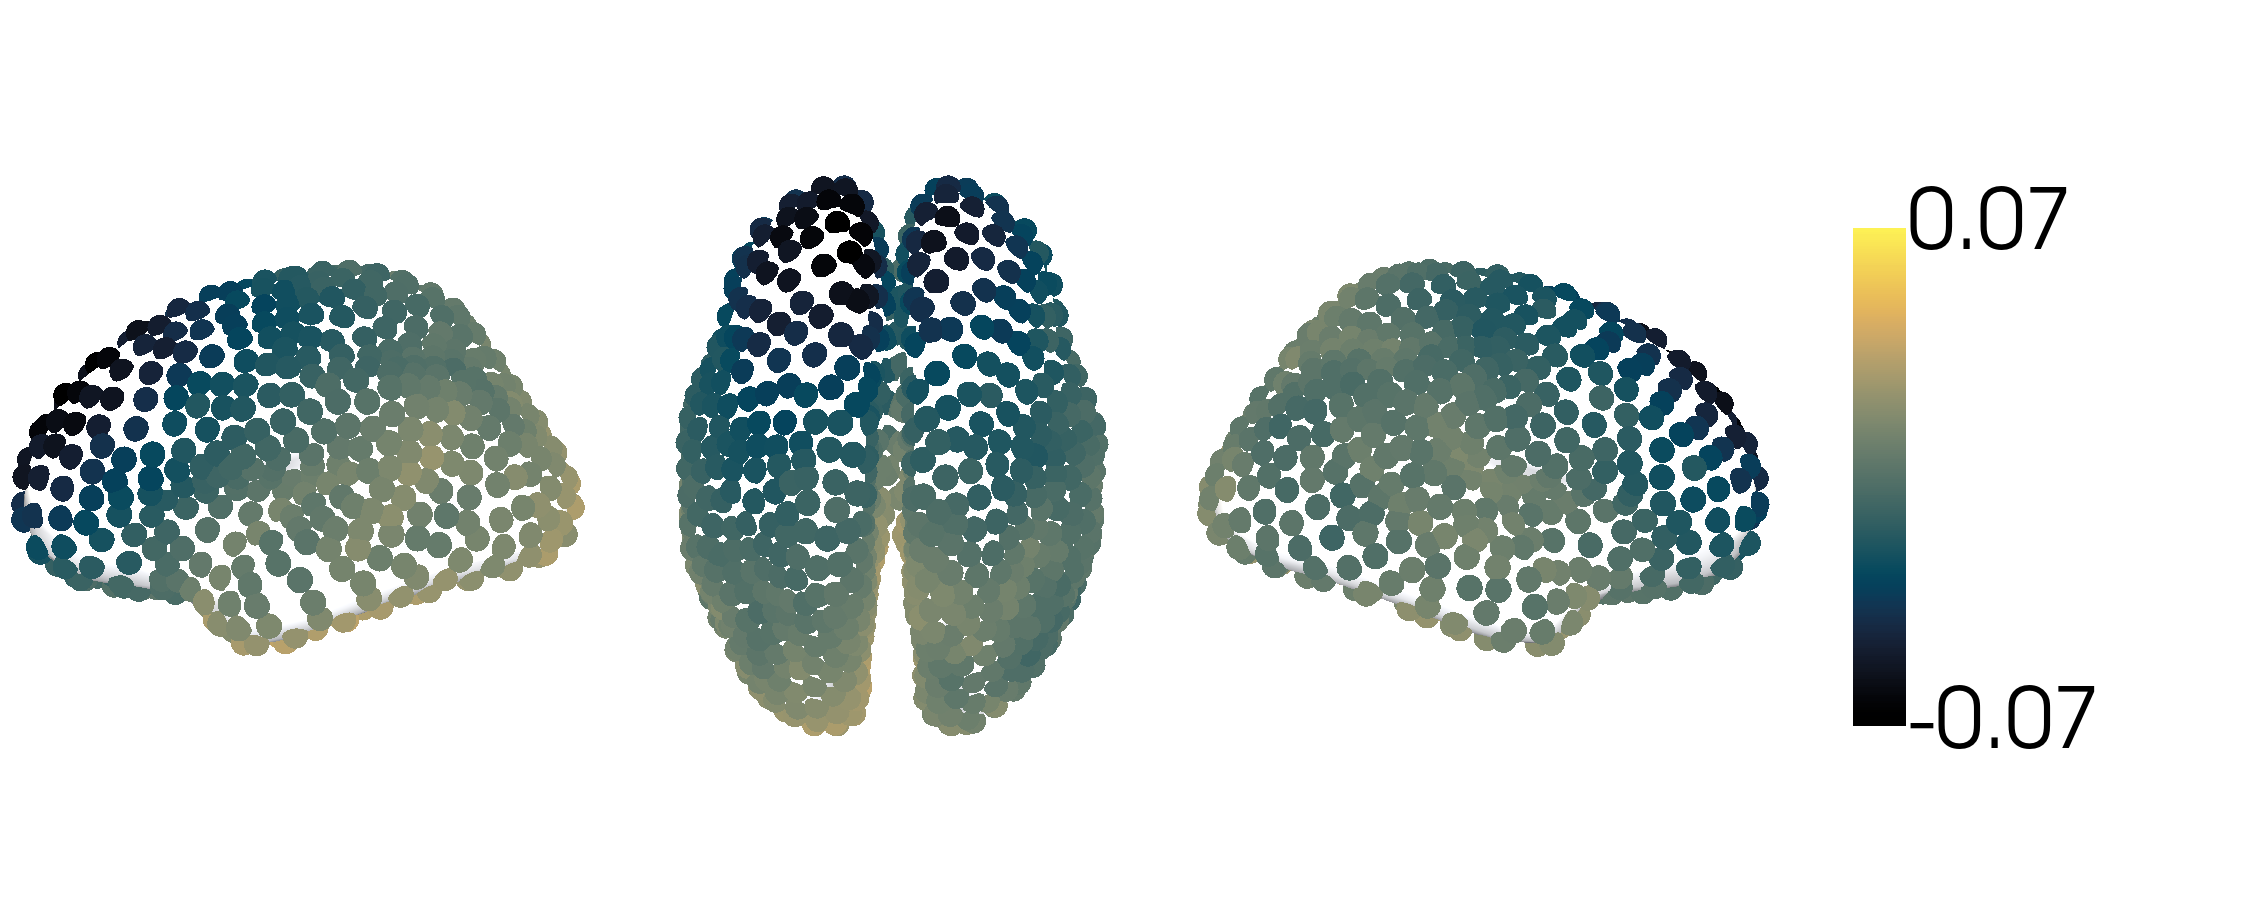

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [14]:
cabs = np.max(np.abs(wave_potential))

plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

#### Plot average instrength-potential correlation

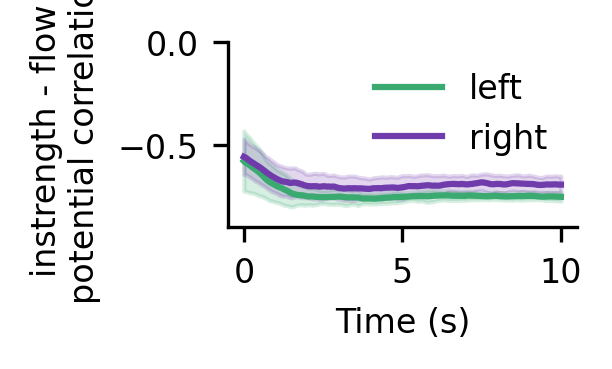

In [10]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.90, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [17]:
# compute instrength - potential correlation
weights_alpha = np.load(os.path.join(data_path, "hcp_meg/nmf_weights_alpha.npy"))
instrength_alpha = weights_alpha.sum(axis=0)

correlation_spin_permutation_testing(instrength_alpha, wave_potential, sphere_path=sphere_path)

	correlation = -0.75 (p < 0.0)



(-0.7487560727560728, 0.0)

#### Effective frequency distribution

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


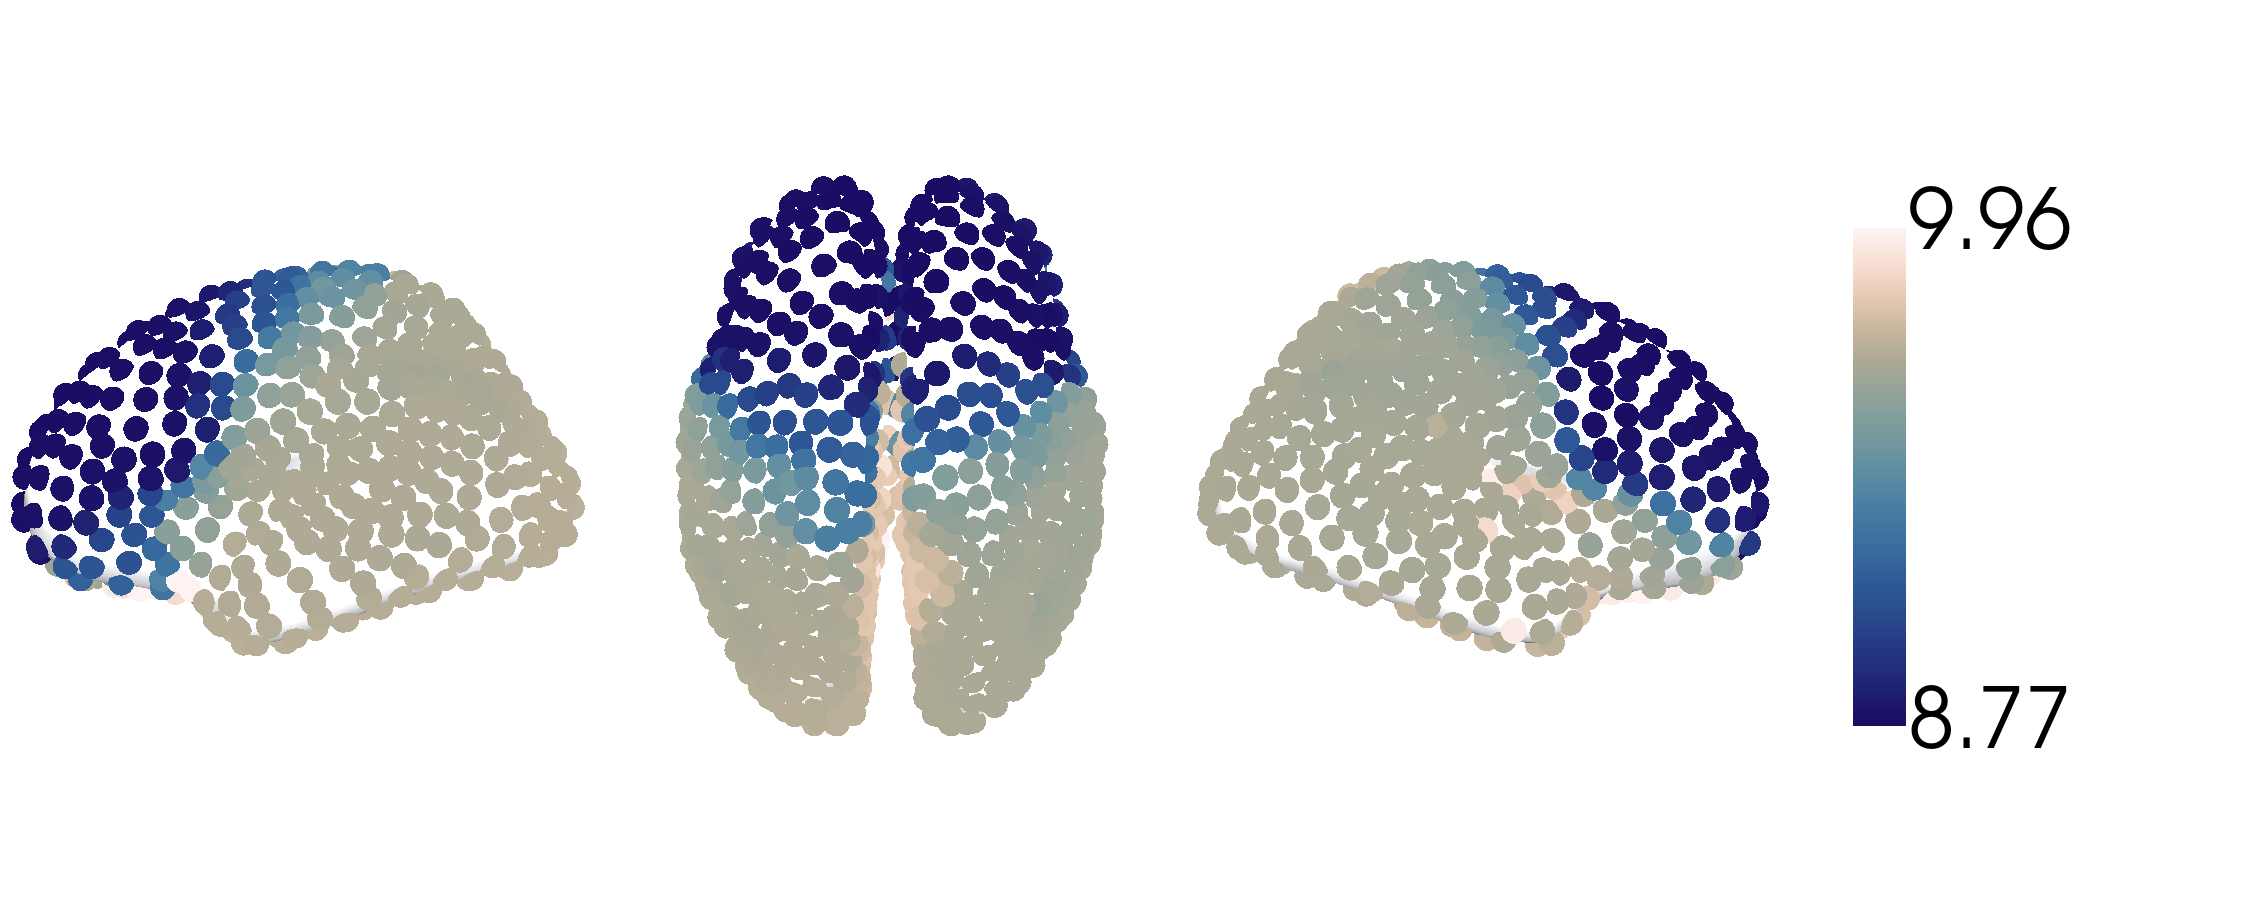

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [15]:
clims = np.percentile(effective_frequency, [1, 99])

plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

In [18]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength_alpha, effective_frequency, sphere_path=sphere_path)

	correlation = -0.77 (p < 0.0)



(-0.7698845778845779, 0.0)

#### Create example movie

In [19]:
# load phase
sid = 0

## load phase
phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sid}.npy")).T
activity = np.cos(phase[:,initial_transient_samples:])

activity = activity[:, np.arange(0, activity.shape[1], integration_step_size_downsampled).astype(int)]

In [20]:
# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/dataset.py:1941: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Beta subnetwork model

### Configuration

In [21]:
experiment_id = '48_beta'

# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = f"/Users/dk/Documents/Charite/PhD/travelingwaves/data/{experiment_id}_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/30_results/figures"
sphere_path=os.path.join(data_path, 'connectomes/Schaefer2018_HCP_S900/positions_sphere.npy')

In [22]:
# Read Configuration
configuration_path = f"../../configuration/{experiment_id}_configuration.yaml"
configuration_analysis_path = f"../../configuration/{experiment_id}_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise
    

# Simulation Parameters
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)
number_of_simulations = len(simulation_ids)

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = int(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient)/integration_step_size_downsampled)


# Analysis Parameters
# -------------------
number_of_permutations = int(config_analysis["number_of_permutations"])
significance_level = float(config_analysis["significance_level"])

## Investigate wave and non-wave episodes

### Load and aggregate data

In [23]:
wave_potential, effective_frequency, corr_mean, corr_sd, order_parameter = aggregate_results(data_path, experiment_id)

Left Hemisphere:8_beta; Simulation ID: 99
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.84 (0.78 - 0.89)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.43 (0.33 - 0.54)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (1.00 - 1.00)
	Average instrength-potential correlation: -0.67 ± 0.02

Right Hemisphere:
	Median (IQR) proportion of source-sink wave episodes across simulation duration: 0.90 (0.86 - 0.95)
	Median (IQR) proportion of rotating wave episodes across simulation duration: 0.28 (0.20 - 0.39)
	Median (IQR) proportion of instrength-guided waves across wave episodes: 1.00  (1.00 - 1.00)
	Average instrength-potential correlation: -0.70 ± 0.02


#### Synchronization

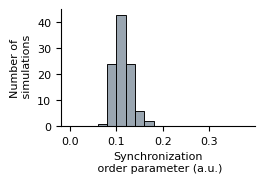

In [24]:
# synchronization
fig, ax = plt.subplots(1, figsize=(2256/dpi/3, 912/dpi/2))

sns.histplot(order_parameter, bins=np.arange(0,0.4,0.02), ax=ax, color='#798897')

plt.ylabel('Number of\n simulations')
plt.xlabel('Synchronization\n order parameter (a.u.)')
sns.despine()

plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_synchronization.svg'), dpi=300, transparent=True, bbox_inches='tight')

#### Average potential

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


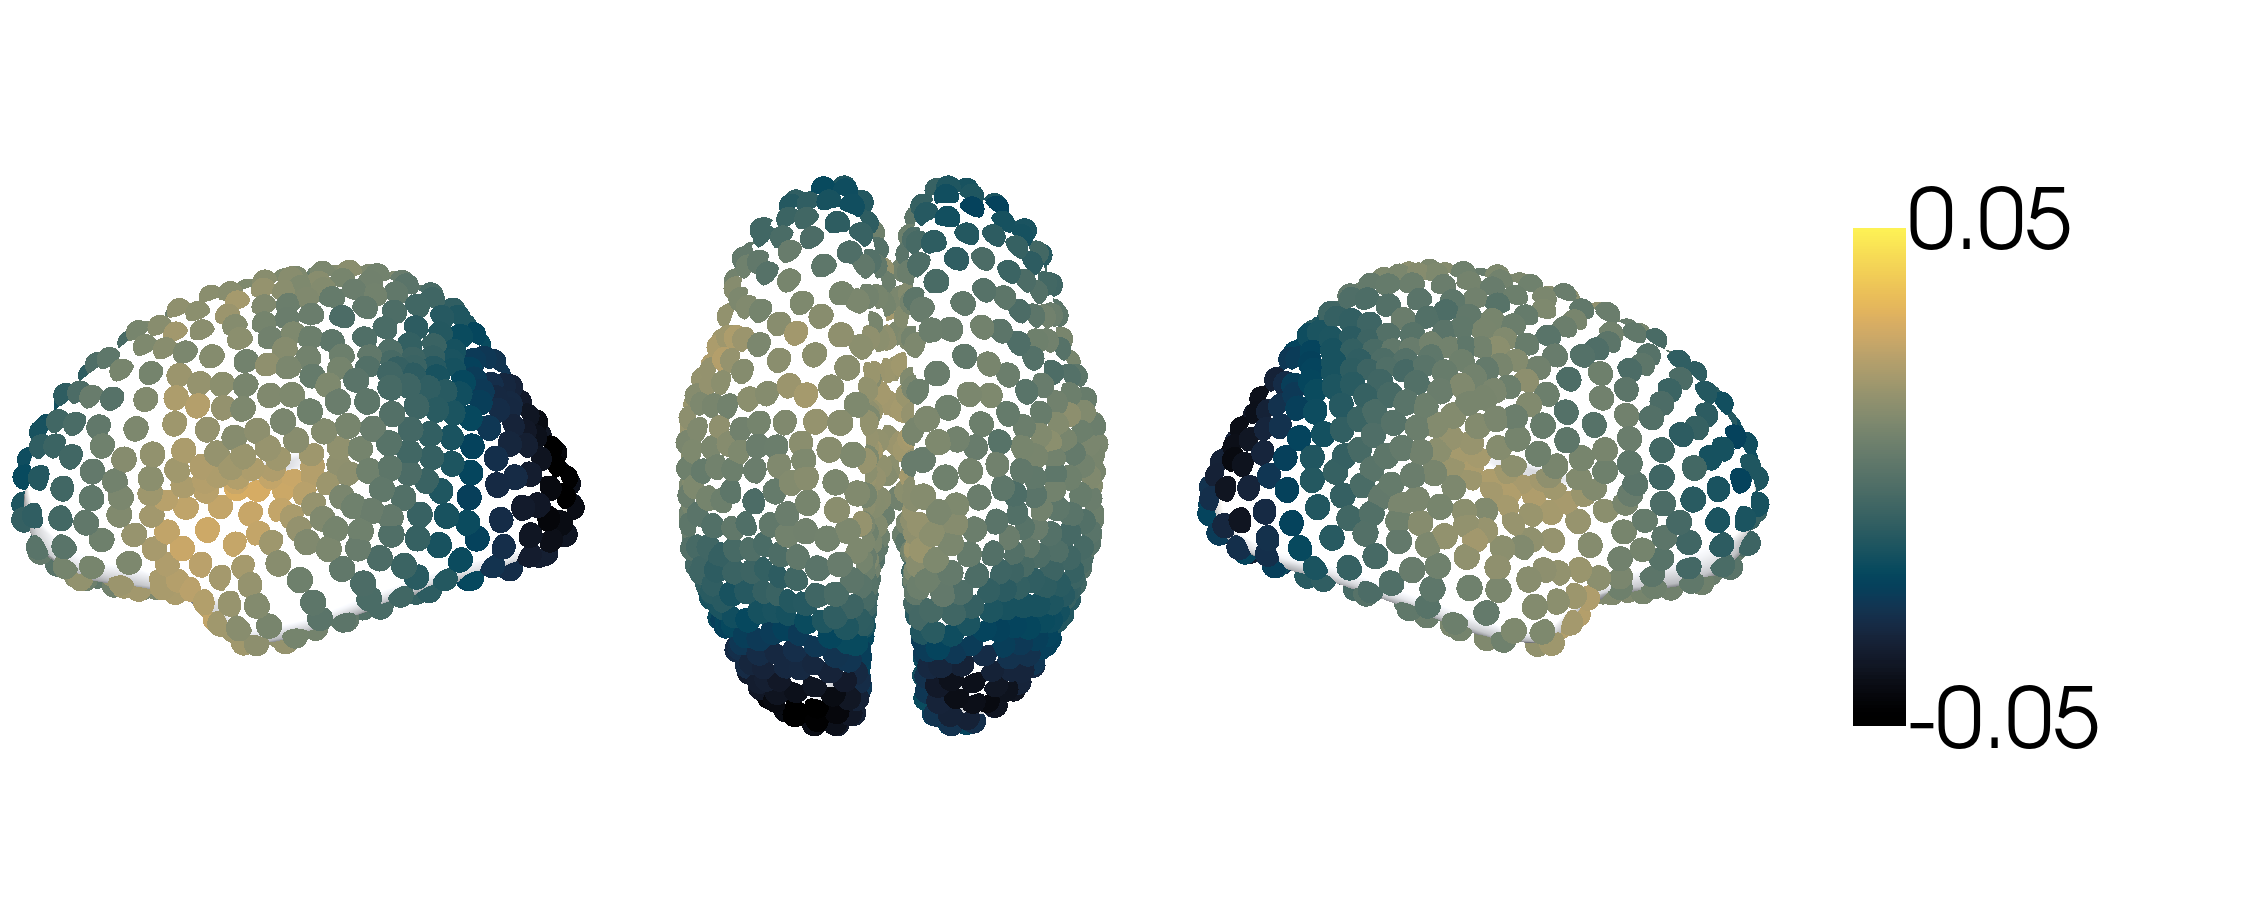

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [25]:
cabs = np.max(np.abs(wave_potential))

plot_brain_data(v, f, wave_potential, cmap=cmap_potential, clim=[-cabs, cabs])
plot_brain_data(v, f, wave_potential, filename=os.path.join(figure_path, f'{experiment_id}_waves_potential_div.png'), cmap=cmap_potential, clim=[-cabs, cabs])

#### Plot average instrength-potential correlation

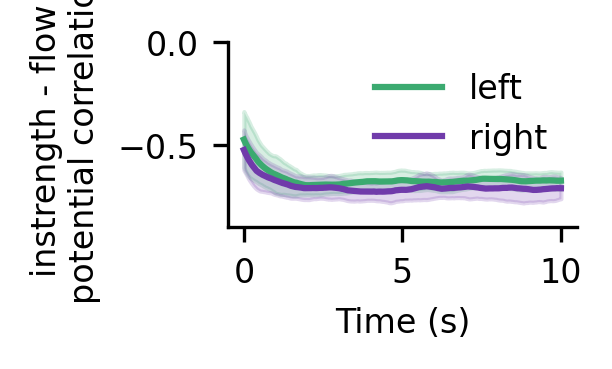

In [26]:
corr_lh_mean = corr_mean[0]
corr_rh_mean = corr_mean[1]
corr_lh_sd = corr_sd[0]
corr_rh_sd = corr_sd[1]

t = np.linspace(0,10,number_of_timesteps_downsampled)  # s

c1 = '#3baa70'
c2 = '#703baa'

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1, figsize=(1.5, .8), dpi=dpi)

ax.plot(t, corr_lh_mean, color=c1, label='left')
ax.fill_between(t, corr_lh_mean-corr_lh_sd, corr_lh_mean+corr_lh_sd, alpha=0.2, color=c1)

ax.plot(t, corr_rh_mean, color=c2, label='right')
ax.fill_between(t, corr_rh_mean-corr_rh_sd, corr_rh_mean+corr_rh_sd, alpha=0.2, color=c2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-0.90, 0])

plt.legend(frameon=False)

plt.xlabel('Time (s)')
plt.ylabel('instrength - flow \npotential correlation')

plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'{experiment_id}_instrength_potential_correlation.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [27]:
# compute instrength - potential correlation
weights_beta = np.load(os.path.join(data_path, "hcp_meg/nmf_weights_beta.npy"))
instrength_beta = weights_beta.sum(axis=0)

correlation_spin_permutation_testing(instrength_beta, wave_potential, sphere_path=sphere_path)

	correlation = -0.78 (p < 0.0)



(-0.7753654633654634, 0.0)

#### Effective frequency distribution

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


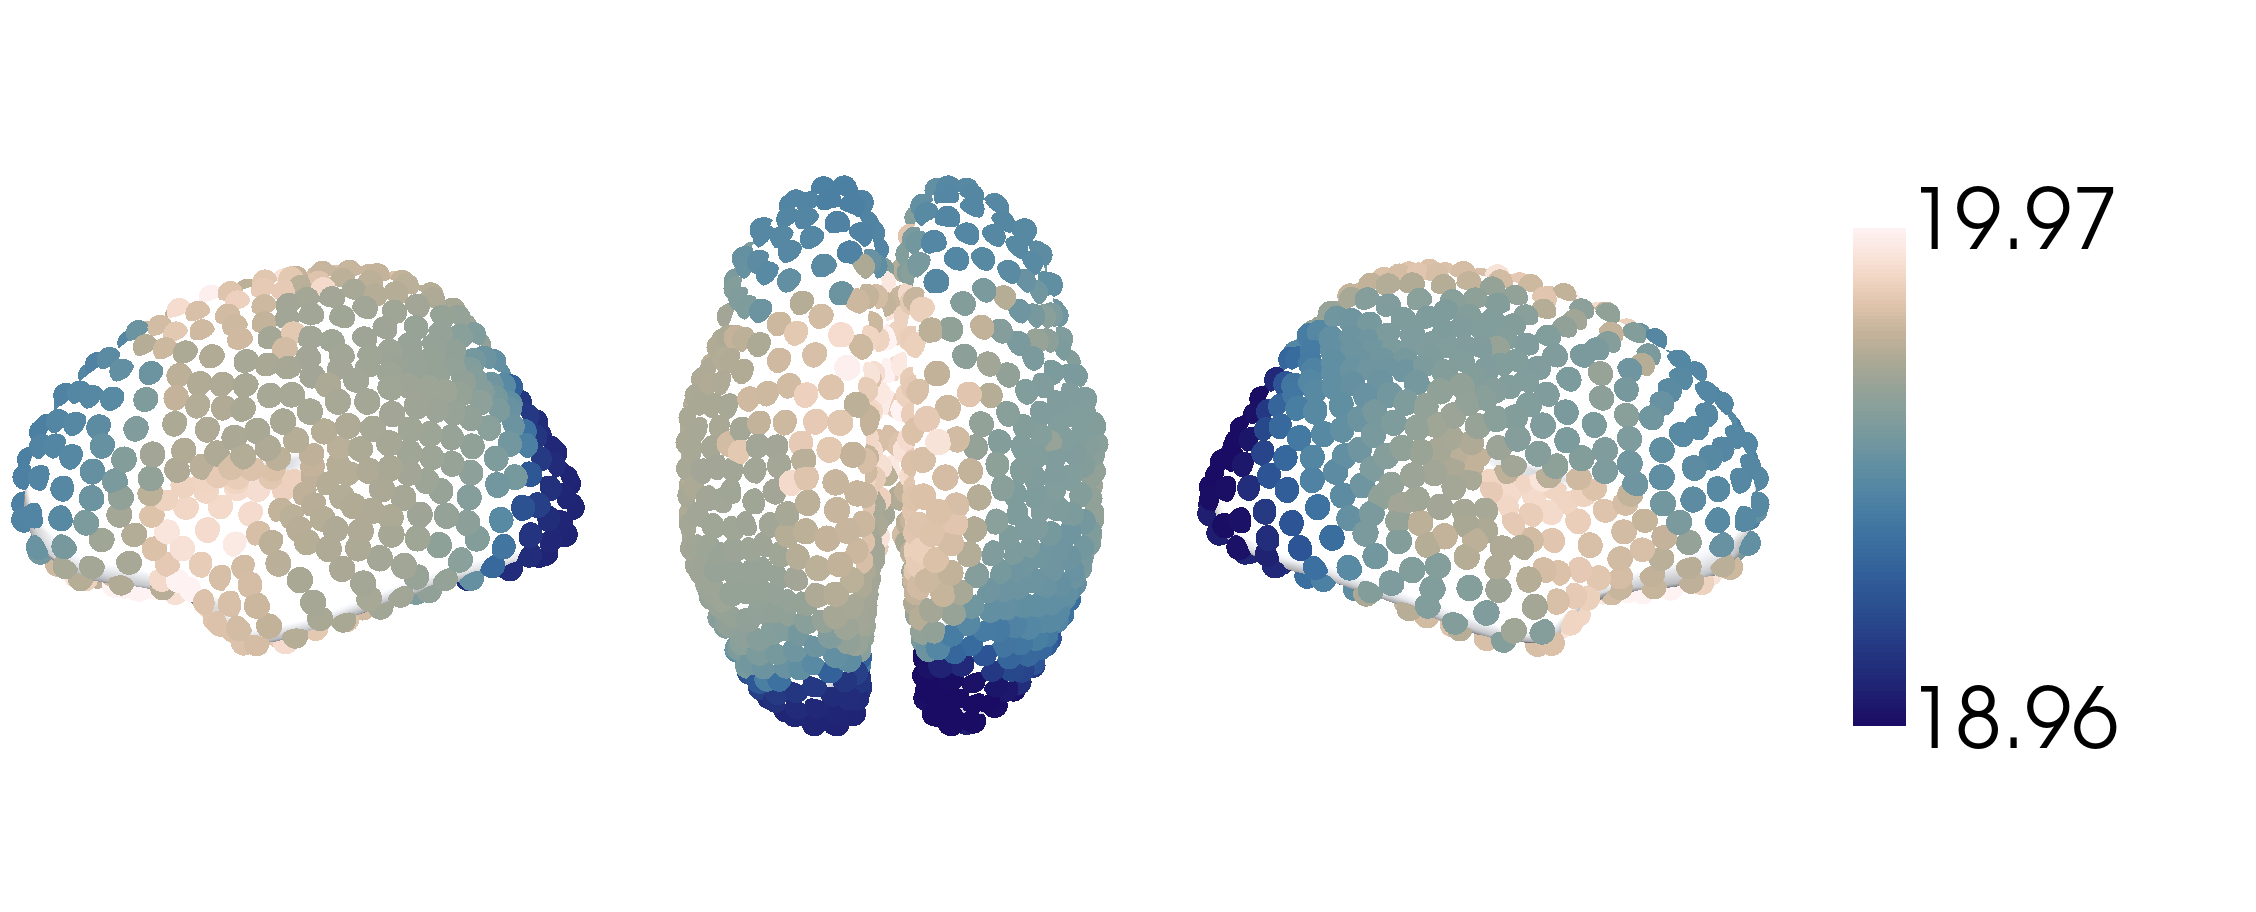

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [28]:
clims = np.percentile(effective_frequency, [1, 99])

plot_brain_data(v, f, effective_frequency, filename=None, cmap=cmap_fq, clim=clims)
plot_brain_data(v, f, effective_frequency, filename=os.path.join(figure_path, f'{experiment_id}_effective_frequency.png'), cmap=cmap_fq, clim=clims)

In [29]:
# Compute instrength - effective frequency correlation
# ----------------------------------------------------
correlation_spin_permutation_testing(instrength_beta, effective_frequency, sphere_path=sphere_path)

	correlation = -0.84 (p < 0.0)



(-0.8405272565272566, 0.0)

#### Create example movie

In [30]:
# load phase
sid = 0

## load phase
phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sid}.npy")).T
activity = np.cos(phase[:,initial_transient_samples:])

activity = activity[:, np.arange(0, activity.shape[1], integration_step_size_downsampled).astype(int)]

In [31]:
# create movie
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)
make_brain_data_movie(v, f, activity, time, 5000, 6000, os.path.join(data_path, f'30_results/movies/{experiment_id}_example_movie.mp4'), cmap=cmap_waves)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/dataset.py:1941: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


# Overview - Proportion traveling waves - Supplemenary models

In [ ]:
c1 = '#3baa70'
c2 = '#703baa'

In [4]:
# Build proportion TWs dataframe
experiment_ids = ['33', '50', '51']
experiments = ['Jansen-Rit', 'Additive noise', 'Random normal\nintrinsic frequency']
number_of_simulations = 100

data = []
for exi, ex_id in enumerate(experiment_ids):
    proportion_waves_lh, proportion_waves_rh, proportion_corr_lh, proportion_corr_rh = aggregate_proportions(data_path, ex_id)
    
    data.append(np.column_stack([np.repeat(experiments[exi], 200),
                                 np.concatenate([['left']*number_of_simulations, ['right']*number_of_simulations]),
                                 np.concatenate([proportion_waves_lh*100, proportion_waves_rh*100]),
                                 np.concatenate([proportion_corr_lh*100, proportion_corr_rh*100])
                                ]))

data = np.vstack(data)

df = pd.DataFrame(data, columns=['Experiment', 'Hemisphere', 'Proportion TWs (%)', 'Proportion guided TWs (%)'])
df['Proportion TWs (%)'] = df['Proportion TWs (%)'].astype(float)
df['Proportion guided TWs (%)'] = df['Proportion guided TWs (%)'].astype(float)

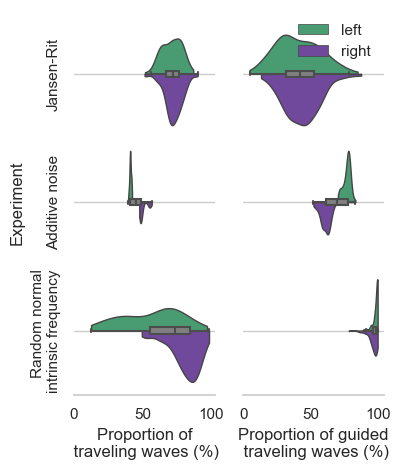

In [72]:
## Plot Proportion Traveling Waves
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,5))
plt.subplot(1,2,1)
p = sns.violinplot(df, x='Proportion TWs (%)', y='Experiment', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
sns.boxplot(df, x='Proportion TWs (%)', y='Experiment', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
p.legend_.remove()
p.set_xlabel('Proportion of\n traveling waves (%)')
p.set_xticks([0, 50, 100])
plt.yticks(rotation=90, va='center')
plt.grid()


plt.subplot(1,2,2)
p = sns.violinplot(df, x='Proportion guided TWs (%)', y='Experiment', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
sns.boxplot(df, x='Proportion guided TWs (%)', y='Experiment', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
p.set_yticklabels([])
p.set_ylabel('')
p.set_xlabel('Proportion of guided\n traveling waves (%)')
p.set_xticks([0, 50, 100])
p.yaxis.set_visible('off')
p.legend(frameon=False)
plt.grid()


sns.despine(left=True)

plt.savefig(os.path.join(figure_path, f'proportion_waves_supp.png'), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'proportion_waves_supp.svg'), dpi=300, transparent=True, bbox_inches='tight')

# Overview - Proportion traveling waves - Subnetwork models

In [45]:
# Build proportion TWs dataframe
experiment_ids = ['48_alpha', '48_beta']
experiments = ['Alpha', 'Beta']
number_of_simulations = 100

data = []
for exi, ex_id in enumerate(experiment_ids):
    proportion_waves_lh, proportion_waves_rh, proportion_corr_lh, proportion_corr_rh = aggregate_proportions(data_path, ex_id)
    
    data.append(np.column_stack([np.repeat(experiments[exi], 200),
                                 np.concatenate([['left']*number_of_simulations, ['right']*number_of_simulations]),
                                 np.concatenate([proportion_waves_lh*100, proportion_waves_rh*100]),
                                 np.concatenate([proportion_corr_lh*100, proportion_corr_rh*100])
                                ]))

data = np.vstack(data)

df = pd.DataFrame(data, columns=['Subnetwork', 'Hemisphere', 'Proportion TWs (%)', 'Proportion guided TWs (%)'])
df['Proportion TWs (%)'] = df['Proportion TWs (%)'].astype(float)
df['Proportion guided TWs (%)'] = df['Proportion guided TWs (%)'].astype(float)

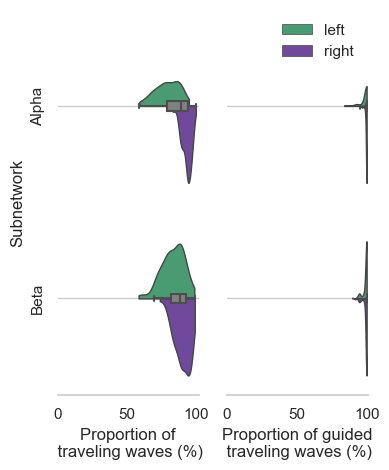

In [49]:
## Plot Proportion Traveling Waves
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,5))
plt.subplot(1,2,1)
p = sns.violinplot(df, x='Proportion TWs (%)', y='Subnetwork', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
sns.boxplot(df, x='Proportion TWs (%)', y='Subnetwork', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
p.legend_.remove()
p.set_xlabel('Proportion of\n traveling waves (%)')
p.set_xticks([0, 50, 100])
plt.yticks(rotation=90, va='center')
plt.grid()


plt.subplot(1,2,2)
p = sns.violinplot(df, x='Proportion guided TWs (%)', y='Subnetwork', hue='Hemisphere', palette=[c1, c2], split=True, cut=0, linewidth=1, inner=None)
sns.boxplot(df, x='Proportion guided TWs (%)', y='Subnetwork', color='gray', width=0.05, boxprops={'zorder': 2}, ax=p, showfliers=False)
p.set_yticklabels([])
p.set_ylabel('')
p.set_xlabel('Proportion of guided\n traveling waves (%)')
p.set_xticks([0, 50, 100])
p.yaxis.set_visible('off')
p.legend(frameon=False)
plt.grid()


sns.despine(left=True)
#
#plt.savefig(os.path.join(figure_path, f'proportion_waves_subnetworks_supp.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'proportion_waves_subnetworks_supp.svg'), dpi=300, transparent=True, bbox_inches='tight')